In [12]:
import matplotlib
from IPython.display import clear_output
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import pulsestreamer
import nifpga
import pyvisa
import serial
import io
import sys
import mdt69x
import time


In [99]:
class ConfocalCounter:
    def __init__(self, reset=True):
        bitfile_path =r'C:\Users\Li_Lab_B12\Desktop\NDController-ver2\FPGA Bitfiles\everythingdaq_FPGATarget2_FPGAConfocalver5_EY5LFETs4tQ.lvbitx'
        self.session = nifpga.Session(bitfile=bitfile_path, resource='RIO0')
        if reset:
            self.session.reset()
            self.session.run()
        else:
            self.session.run()
        self.host2target = self.session.fifos['FIFO_Host2Target']
        self.host2target.configure(10)
        self.target2host = self.session.fifos['FIFO_target2host']
        self.target2host.configure(10)
        

    def get_counts(self, x, y, parameters):
        xy_volts = np.array([
            (x - parameters['samples_per_axis'] // 2) * parameters['scale'],
            (y - parameters['samples_per_axis'] // 2) * parameters['scale']
        ])
        count_ticks = 40000 * parameters['count_time (ms)']

        self.session.registers['Full Loop Timer(Ticks)'].write(count_ticks + 12 * 40000)
        self.session.registers['AO4'].write(16500 if parameters['LED'] else 0)
        self.session.registers['WaitTime(ticks)'].write(10 * 40000)
        self.session.registers['Counting Time (tick)'].write(count_ticks)

        self.host2target.write(xy_volts)
        self.host2target.start()

        count = self.target2host.read(number_of_elements=1, timeout_ms=-1)
        return count.data[0]
    
    def perform_2d_scan(self, parameters):
        # Initialize a 101x101 array with zeros
        scan_data = np.zeros((parameters['samples_per_axis'],parameters['samples_per_axis']))

        # set colormap
        # r'C:\Users\Li_Lab_B12\Desktop\DataSumukh\250731_PythonCode\colormap_LiLab.csv'
        LiLabColormap =matplotlib.colors.ListedColormap(np.loadtxt('.\\colormap_LiLab.csv', delimiter=','), name='Lilab', N=None)

        # Perform the scan row by row
        self.get_counts(parameters['samples_per_axis']//2, parameters['samples_per_axis']//2, parameters)

        for x in tqdm(range(parameters['samples_per_axis'])):
            for y in range(parameters['samples_per_axis']):
                scan_data[x, y] = self.get_counts(x, y, parameters)  # Update the array with scanned data
            clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(12,10))
            im = ax.imshow(scan_data, cmap=LiLabColormap, interpolation='nearest')
            fig.colorbar(im, label='Counts')
            plt.pause(0.01)
            
        self.get_counts(parameters['samples_per_axis']//2, parameters['samples_per_axis']//2, parameters)  # Final call to ensure the last point is captured
        return scan_data




    def close(self):
        self.session.close()

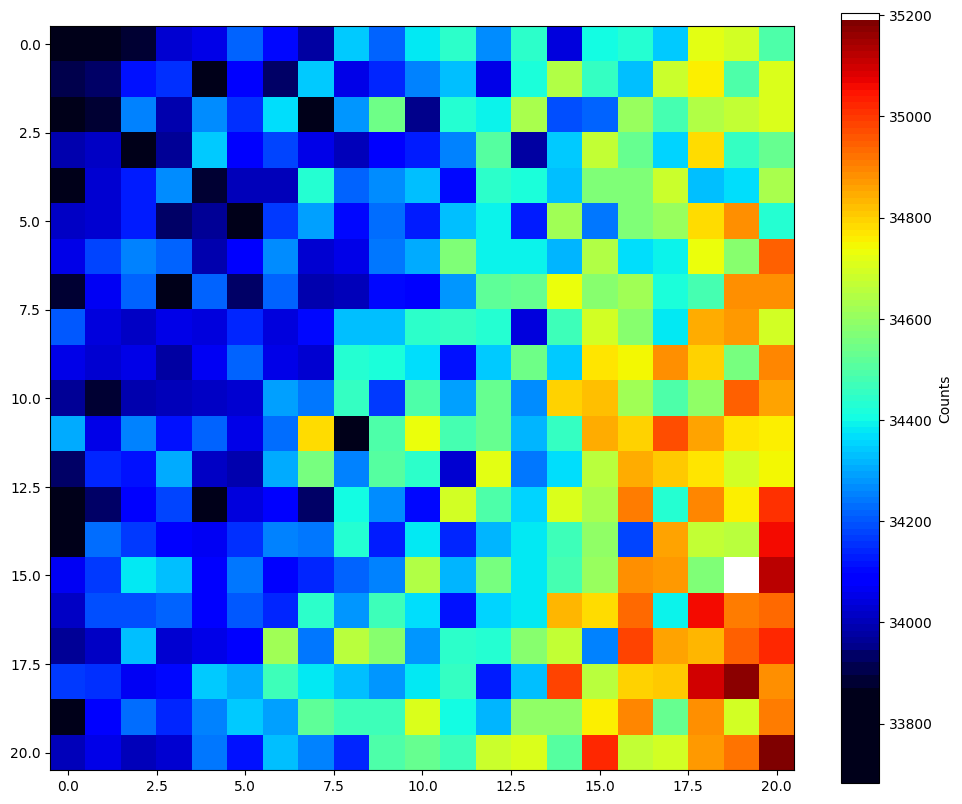

100%|██████████| 21/21 [00:11<00:00,  1.81it/s]


In [100]:
parameters = {
'samples_per_axis' : 21,
'scale' : 4,
'count_time (ms)': 10, 
'LED': False,
'reset': True
}
x,y = parameters['samples_per_axis']//2, parameters['samples_per_axis']//2

# confocal.close()


confocal = ConfocalCounter()

# def perform_2d_scan():
#     # Initialize a 101x101 array with zeros
#     scan_data = np.zeros((parameters['samples_per_axis'],parameters['samples_per_axis']))

#     # Create an instance of the confocalCounter class
    

#     # Perform the scan row by row
#     confocal.get_counts(parameters['samples_per_axis']//2, parameters['samples_per_axis']//2, parameters)

#     for x in tqdm(range(parameters['samples_per_axis'])):
#         for y in range(parameters['samples_per_axis']):
#             scan_data[x, y] = confocal.get_counts(x, y, parameters)  # Update the array with scanned data
#         clear_output(wait=True)
#         fig, ax = plt.subplots(figsize=(12,10))
#         im = ax.imshow(scan_data, cmap='jet', interpolation='nearest')
#         fig.colorbar(im, label='Counts')
#         plt.pause(0.01)
        
#     confocal.get_counts(parameters['samples_per_axis']//2, parameters['samples_per_axis']//2, parameters)  # Final call to ensure the last point is captured
#     return scan_data

# conf_data=perform_2d_scan()

conf_data = confocal.perform_2d_scan(parameters)
confocal.close()




# xdata, ydata = [],[]
# for i in range(400):
#     xdata.append(i)
#     ydata.append(confocal.get_counts(x, y, parameters))
#     parameters['reset'] =False

#     clear_output(wait = True)

#     fig, ax = plt.subplots()
#     ax.plot(xdata, ydata)
#     plt.show()

# confocal.close()

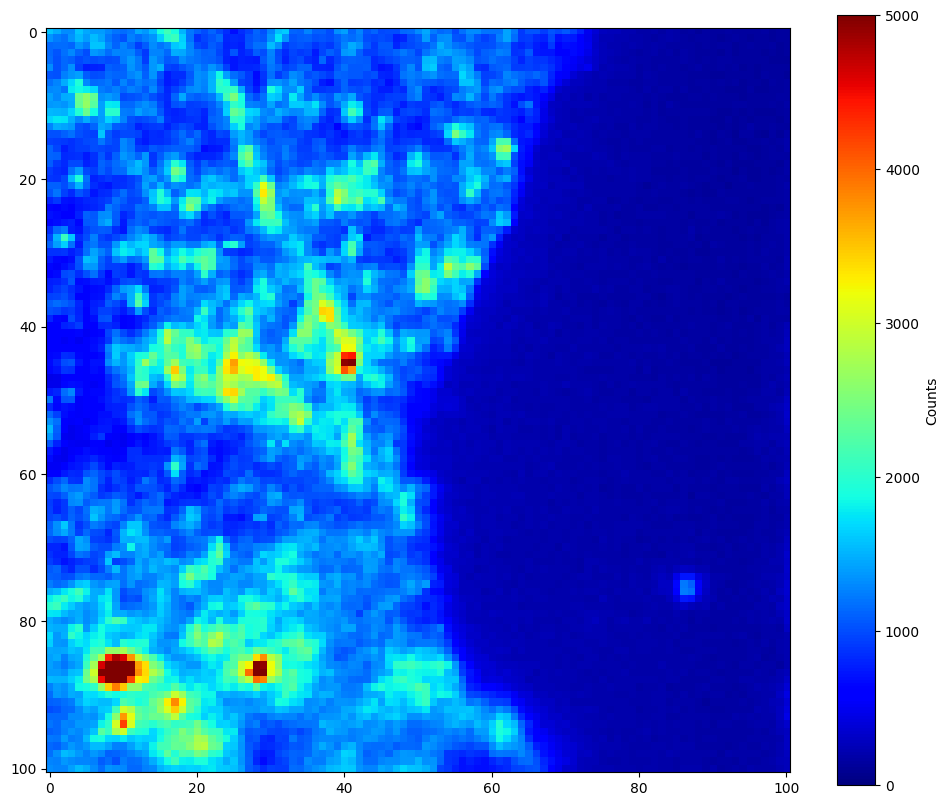

In [49]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(conf_data, cmap='jet', interpolation='nearest', vmin=0, vmax=5e3)
fig.colorbar(im, label='Counts')

In [ ]:
# def get_confocal_counts(x, y, parameters):
#     fpga_bitfile = r'C:\Users\Li_Lab_B12\Desktop\NDController-ver2\FPGA Bitfiles\everythingdaq_FPGATarget2_FPGAConfocalver5_EY5LFETs4tQ.lvbitx'

#     xy_volts = np.array(((x - parameters['samples_per_axis'] //2)*parameters['scale'],(y - parameters['samples_per_axis'] //2)*parameters['scale']))
#     count_ticks = 40000* parameters['count_time (ms)']

#     with nifpga.Session(bitfile=fpga_bitfile, resource="RIO0") as session:
#                 if parameters['reset']: 
#                         session.reset()
#                         session.run()
#                 host2target = session.fifos['FIFO_Host2Target']
#                 host2target.configure(10000)
#                 session.registers['Full Loop Timer(Ticks)'].write(count_ticks+12*40000)
#                 if parameters['LED']:
#                         session.registers['AO4'].write(16500)
#                 else:
#                         session.registers['AO4'].write(0)

#                 session.registers['WaitTime(ticks)'].write(10*40000)
#                 session.registers['Counting Time (tick)'].write(count_ticks)
#                 host2target.write(xy_volts)

#                 target2host=session.fifos['FIFO_target2host']
#                 target2host.configure(10)
                
#                 host2target.start()
                
#                 count = target2host.read(number_of_elements=1, timeout_ms = -1)
            
#     return count.data[0]


    
        
        

In [ ]:
# parameters = {
# 'samples_per_axis' : 101,
# 'scale' : 4,
# 'count_time (ms)': 100, 
# 'LED': False,
# 'reset': True
# }
# x,y = 51,51

# xdata, ydata = [],[]
# for i in range(400):
#     xdata.append(i)
#     ydata.append(get_confocal_counts(x, y, parameters))
#     parameters['reset'] =False

#     clear_output(wait = True)

#     fig, ax = plt.subplots()
#     ax.plot(xdata, ydata)
#     plt.show()

    

FifoReservedError: Error: FifoReserved (-63082) when calling 'NiFpgaDll_ConfigureFifo2' with arguments:
	session: 0x30504
	fifo: 0x1
	requested depth: 0x2710
	actual depth: 0x0

In [76]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

jet = cm.get_cmap('jet', 100)
print(jet)

mapping = jet(np.linspace(0, 1, 100))
print(mapping)

lilab_colormap = np.zeros((102, 4))
lilab_colormap[:2,:] = np.array([[ 0., 0., 0.1,  1.],[ 0., 0., 0.1,  1.]])
lilab_colormap[2:,:] = mapping

print(lilab_colormap)

np.savetxt('colormap_LiLab.csv', lilab_colormap, delimiter=',')

[[0.         0.         0.5        1.        ]
 [0.         0.         0.54591368 1.        ]
 [0.         0.         0.59182736 1.        ]
 [0.         0.         0.63774105 1.        ]
 [0.         0.         0.68365473 1.        ]
 [0.         0.         0.72956841 1.        ]
 [0.         0.         0.77548209 1.        ]
 [0.         0.         0.82139578 1.        ]
 [0.         0.         0.86730946 1.        ]
 [0.         0.         0.91322314 1.        ]
 [0.         0.         0.95913682 1.        ]
 [0.         0.         1.         1.        ]
 [0.         0.         1.         1.        ]
 [0.         0.02525253 1.         1.        ]
 [0.         0.06565657 1.         1.        ]
 [0.         0.10606061 1.         1.        ]
 [0.         0.14646465 1.         1.        ]
 [0.         0.18686869 1.         1.        ]
 [0.         0.22727273 1.         1.        ]
 [0.         0.26767677 1.         1.        ]
 [0.         0.30808081 1.         1.        ]
 [0.         

C:\Users\Li_Lab_B12\AppData\Local\Temp\ipykernel_120324\3693624377.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap('jet', 100)


In [91]:
# Loading the colormap
LiLabColormap =matplotlib.colors.ListedColormap(np.loadtxt('colormap_LiLab.csv', delimiter=','), name='Lilab', N=None)

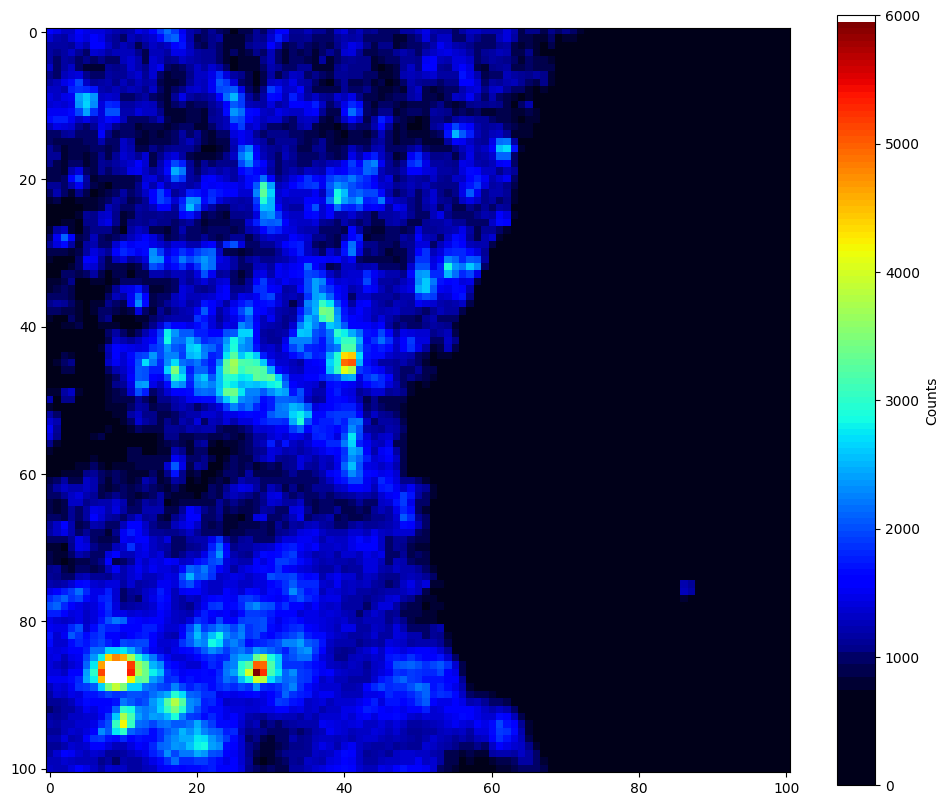

In [95]:
fig, ax = plt.subplots(figsize=(12,10))
im = ax.imshow(conf_data, cmap=LiLabColormap, interpolation='nearest', vmin=0, vmax=6e3)
fig.colorbar(im, label='Counts')